In [242]:
!pip install transformers datasets torch scikit-learn
!pip install tf-keras
!pip install tensorflow
!pip install transformers
!pip install --upgrade tensorflow transformers

import pandas as pd
import numpy as np
import os
import re
import string
from time import time
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

from transformers import (
    TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification,
    BertTokenizer, TFGPT2LMHeadModel, GPT2Tokenizer, TFAutoModelForSequenceClassification
)

In [243]:
import matplotlib.pyplot as plt

In [244]:
dataTrain = pd.read_csv("data/train.csv")
dataTest = pd.read_csv("data/test.csv")
dataSampleSubmit = pd.read_csv("data/sample_submission.csv")

disasters = []
locations = [] 
total_words = []
for row in dataTrain.itertuples(index=True):
    if pd.notna(row.keyword): 
        if row.keyword not in disasters:
            disasters.append(row.keyword)
    if pd.notna(row.location): 
        if row.location not in locations:
            locations.append(row.location)
            
    words = row.text.split() 
    for word in words:
        total_words.append(word)
    
    
unique_word_count = set(total_words)

# Get the words occurring the most in the data
words_df = {'word':total_words}
words_df = pd.DataFrame(data=words_df)
populars = words_df.value_counts()

In [245]:
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
     # Remove links from tweet texts
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters, mentions and hashtages, as well as numbers from tweet texts
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords (words that don't add anything meaningful to the text)
    stopword = set(stopwords.words('english'))
    # Manually added stopwords
    extrastopwords = ["im", "like", "get", "dont", "wont", "via", "still", "would", "got", "rt", "cant", "theyre", "bb", "fyi", "hmu", "th", "st", "rd"]
    extrastopwords = set(extrastopwords)
    text = " ".join([word for word in text.split() if word not in stopword])
    text = " ".join([word for word in text.split() if word not in extrastopwords])

    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    text_lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    text_lemmas = "".join([word for word in text_lemmas])
    return text_lemmas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanasauo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vanasauo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vanasauo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\vanasauo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [272]:
total_df = pd.DataFrame({'word':total_words})

disasters = dataTrain.loc[dataTrain['target'] == 1]
disaster_words = []
for row in disasters.itertuples():
    disaster_text = row.text.split() 
    for word in disaster_text:
        disaster_words.append(word)

In [273]:
for word in disaster_words:
    word.replace("-", "")

disaster_words_processed = [preprocess_text(vastus) for vastus in disaster_words]

In [278]:
for word in disaster_words_processed:
    word = word.strip()
    word = word.replace("\t", "")
    word = word.replace("\n", "")
    word = word.replace(" ", "")

disaster_df = pd.DataFrame({'word':disaster_words})
dw_processed_df = pd.DataFrame({'word': disaster_words_processed})

disaster_df.replace('-', np.nan, inplace=True)
disaster_df.dropna(inplace=True)

dw_processed_df.replace('', np.nan, inplace=True)
dw_processed_df.dropna(inplace=True)

In [279]:


dw_processed_df['word'].value_counts().head()

word
fire        268
kill        156
news        138
flood       120
disaster    118
Name: count, dtype: int64

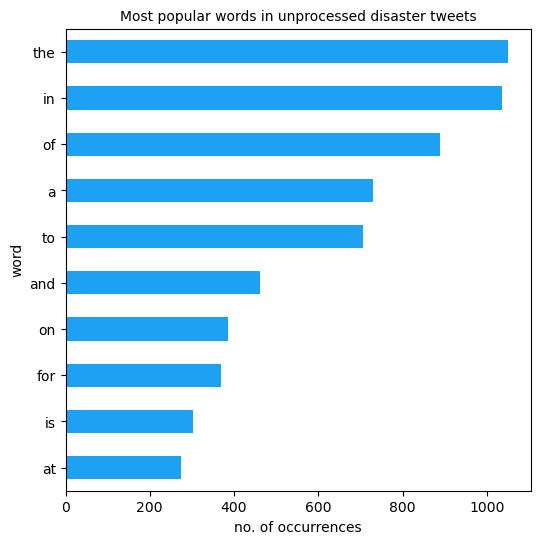

In [298]:
plt.figure(figsize=(6,6))
disaster_df['word'].value_counts().head(10).plot(kind="barh", color='#1DA1F2')
plt.gca().invert_yaxis()
plt.ylabel("word")
plt.xlabel("no. of occurrences")
plt.yticks(fontsize=10)
plt.title("Most popular words in unprocessed disaster tweets", fontsize=10)
plt.savefig('unprocessed2.pdf') 
plt.show()


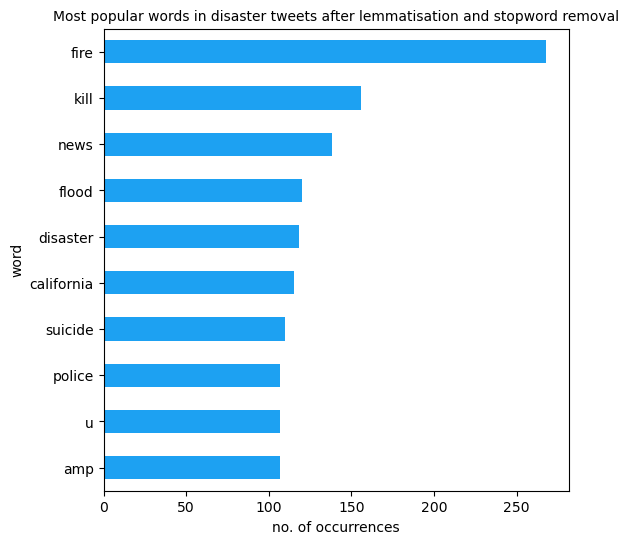

In [300]:
plt.figure(figsize=(6,6))
dw_processed_df['word'].value_counts().head(10).plot(kind="barh", color='#1DA1F2')
plt.gca().invert_yaxis()
plt.title("Most popular words in disaster tweets after lemmatisation and stopword removal", fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("word")
plt.xlabel("no. of occurrences")
plt.savefig('processed2.pdf', bbox_inches="tight", pad_inches=0.2) 
plt.show()
